# 1. TCFD Recommended Disclosure Classifiers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
df_page = pd.read_excel('/project/Data/kw_predict_page_new.xlsx',encoding='utf-8',index_col=0)

In [3]:
# Select only useful features
df_page_short= df_page.loc[df_page['Climate']==1,['file_name','firm_name','year','total_page',
               'page_number','raw_text','header','report_type','Climate','Sector']].copy()

In [4]:
df_page_short.drop_duplicates(subset=['file_name','raw_text'],inplace=True)

In [5]:
df_page_short['row'] = df_page_short.index

In [6]:
df_page_short.shape

(971, 11)

# 1.1 Data Preprocessing

### 1.1.1 Modify Actual Year for ESG reports of HSBC

In [7]:
# For all other reports of HBSC, year-1 
for i,r in df_page_short.iterrows():
    if r['firm_name'] == 'HSBC_Holdings_Plc' and r['report_type'] == 'Other':
        ori = df_page_short.at[i,'year']
        df_page_short.at[i,'year'] = ori-1

### 1.1.2 Read and Transform TCFD Labels

In [8]:
# read in labels
df_tcfd_label = pd.read_excel('/project/Data/tcfd_page_label.xlsx',encoding='utf-8',index_col=0)
df_tcfd_label2 = pd.read_excel('/project/Data/tcfd_page_label2.xlsx',encoding='utf-8',index_col=0)
df_tcfd_label3 = pd.read_excel('/project/Data/tcfd_page_label3.xlsx',encoding='utf-8',index_col=0)
df_tcfd_label4 = pd.read_excel('/project/Data/tcfd_page_label4.xlsx',encoding='utf-8',index_col=0)

In [11]:
def get_label(df_1,df_2,df_3,df_4,index):
    if index in df_1.index:
        return df_1.loc[index,'TCFD']
    elif index in df_2.index:
        return df_2.loc[index,'TCFD']
    elif index in df_3.index:
        return df_3.loc[index,'TCFD']
    elif index in df_4.index:
        return df_4.loc[index,'TCFD']
    else: return np.nan

In [13]:
df_page_short['TCFD'] = df_page_short.row.apply(lambda x: 
                                                get_label(df_tcfd_label,
                                                          df_tcfd_label2,
                                                         df_tcfd_label3,
                                                          df_tcfd_label4,
                                                         x))

In [14]:
df_page_short['labelled'] = df_page_short.TCFD.apply(lambda x: 0 if pd.isna(x) else 1)

In [18]:
df_page_short['TCFD'] = df_page_short.TCFD.apply(lambda x: x.split('|') if isinstance(x,str) else x)

In [19]:
label = []
for index,row in df_page_short.iterrows():
    if isinstance(row['TCFD'],list):
        label = label+row['TCFD']
        if '' in row['TCFD']:
            print(index)
label_unique = list(set(label))
label_unique.sort()
label_unique.append('other')

In [20]:
label_unique

['gov_a',
 'gov_b',
 'metrics_a',
 'metrics_b',
 'metrics_c',
 'risk_a',
 'risk_b',
 'risk_c',
 'str_a',
 'str_b',
 'str_c',
 'other']

In [21]:
# generate label dummies
for i in label_unique:
    df_page_short[i] = np.nan
    
for index,row in df_page_short.iterrows():
    tcfd = row['TCFD']
    if isinstance(tcfd,list):
        for i in tcfd:
            df_page_short.at[index,i] = 1
    elif tcfd == 0 or tcfd == -1:
        df_page_short.at[index,'other'] = 1
    else:pass

### 1.1.3 Text Pre-processing: Data Cleaning and Feature Engineering

In [9]:
def remove_link(text):
    type_list = [r'https://[^\s]+','http://[^\s]+',r'www\.[^\s]+',
                 r'[^\s]+\.html','[^\s]+@[^\s]+','[^\s]+\.com[^\s]+']
    for t in type_list:
        text = re.sub(t,'',text)
    return text

In [10]:
def clean_text(text,keep_punc=False):#keep only letters
    if keep_punc == True:
        text = re.sub(r"[^A-Za-z.,']",' ',text)
        text = re.sub(r' {2,}',' ',text)
    else: 
        text = re.sub(r'[^A-Za-z ]',' ',text)
        text = re.sub(r' {2,}',' ',text)
    return text

In [15]:
df_page_short['clean_text'] = df_page_short.raw_text.apply(lambda x: remove_link(x))
df_page_short['clean_text_lower'] = df_page_short.raw_text.apply(lambda x: remove_link(x).lower())

In [16]:
df_page_short['clean_text'] = df_page_short.clean_text_lower.apply(lambda x: clean_text(x,True))
df_page_short['clean_text_lower'] = df_page_short.clean_text_lower.apply(lambda x: clean_text(x))

In [17]:
df_page_short['contains_tcfd'] = df_page_short.clean_text_lower.apply(lambda x: 1 
                                                                      if re.search('tcfd',x)
                                                                     else 0)

In [25]:
#sampling for manual label
# df_tcfd_label = df_page_short.groupby('contains_tcfd', 
#                                       group_keys=False).apply(lambda x: x.sample(n=50,random_state=0))
# df_tcfd_label.to_excel('/project/Data/tcfd_page_label.xlsx',encoding='utf-8')
# #sample for a second time
# df_samplesource = df_page_short.loc[df_page_short['Labelled']==0,:].copy()
# df_sample1 = df_samplesource.loc[df_samplesource['contains_tcfd']==1,:].copy()
# df_sample2 = df_samplesource.sample(n=102,random_state=0)
# # forgot to remove the sample contains tcfd, need to resample five more sample 8/24
# df_tcfd_label2 = pd.concat([df_sample1,df_sample2])
# df_tcfd_label2.drop(columns=label_unique,inplace=True)
# df_tcfd_label2.to_excel('/project/Data/tcfd_page_label2.xlsx',encoding='utf-8')
#add 5 more smaple
# df_samplesource.drop(df_tcfd_label2.index,inplace=True)
# df_tcfd_label3 = df_samplesource.sample(n=5,random_state=0)
# df_tcfd_label3.to_excel('/project/Data/tcfd_page_label3.xlsx',encoding='utf-8')
# #08/27
# df_tcfd_label4 = df_page_short.loc[df_page_short['labelled']==0,:].sample(n=25,random_state=0)
# df_tcfd_label4.to_excel('/project/Data/tcfd_page_label4.xlsx',encoding='utf-8')

In [381]:
df_page_short['contains_tcfd'].value_counts() 

0    823
1    148
Name: contains_tcfd, dtype: int64

In [22]:
import spacy
try:
    nlp = spacy.load("en_core_web_md")
except OSError:
    import spacy.cli 
    print("Model not found. Downloading.")
    spacy.cli.download("en_core_web_md")
    import en_core_web_md
    nlp = en_core_web_md.load()
    
nlp = spacy.load('en_core_web_md', disable=['tagger', 'parser', 'ner'])

In [23]:
all_stopwords = nlp.Defaults.stop_words

In [24]:
#only keep the word that are longer than 2 character
df_page_short['tokens'] = df_page_short.clean_text_lower.apply(lambda x:\
                          [str(tok.lemma_).lower() for tok in nlp(x)\
                          if tok.text.lower() not in all_stopwords and len(tok)>2]) 

In [26]:
df_all = df_page_short.loc[df_page_short['labelled']==1,:].copy()
df_all.fillna(0,inplace=True)

In [27]:
y_all = df_all.loc[:,label_unique].copy()

In [383]:
y_all.describe().to_excel('/project/Data/label.xlsx')

In [29]:
df_all['tokens_str'] = df_all.tokens.apply(lambda x: ' '.join(x))

In [30]:
from sklearn.model_selection import train_test_split 
X_train, X_val_ori, y_train, y_val_ori = train_test_split(
    df_all.loc[:,['tokens','tokens_str']],y_all, test_size=0.35, random_state=42)

In [31]:
X_val, X_test, y_val, y_test = train_test_split(
    X_val_ori,y_val_ori, test_size=0.42, random_state=42) #val accounts for 20% of the original set

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train['tokens_str']).toarray()
X_val_bow = vectorizer.transform(X_val['tokens_str']).toarray()
X_test_bow = vectorizer.transform(X_test['tokens_str']).toarray()

In [33]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
X_train_tfidf = tfidfconverter.fit_transform(X_train_bow).toarray()
X_val_tfidf = tfidfconverter.transform(X_val_bow).toarray()
X_test_tfidf = tfidfconverter.transform(X_test_bow).toarray()

## 1.2 Machine Learning Method: Train 11 classifiers with SVC,RandomForest, and XGBoost

### 1.2.1 Dimensionality Reduction

134


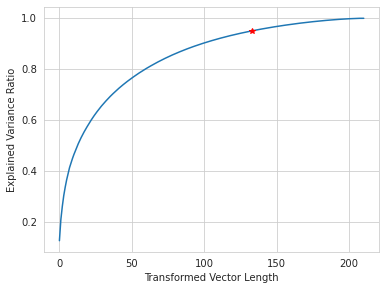

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
n = 211
svd = TruncatedSVD(n_components=n, n_iter=5, random_state=0)
svd.fit(X_train_bow)
sns.set_style("whitegrid") 
%matplotlib inline
plt.figure(figsize=(4*1.5,3+1.5))
y = np.cumsum(svd.explained_variance_ratio_)
x = list(range(n))
sns.lineplot(x,y)
components = np.argmax(y>=0.95)+1
plt.xlabel('Transformed Vector Length')
plt.ylabel('Explained Variance Ratio')
#plt.title('SVD Components Explained Variance Ratio for Bag-of-Words Representation')
plt.plot(x[components-1], y[components-1], 'r*')
print(components)
plt.show()

174


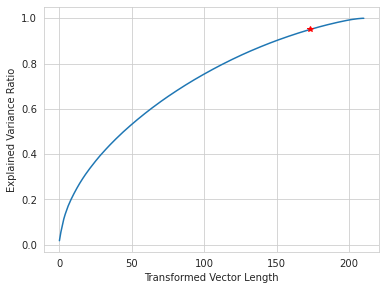

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
n = 211
svd_tfidf = TruncatedSVD(n_components=n, n_iter=5, random_state=0)
svd_tfidf.fit(X_train_tfidf)
sns.set_style("whitegrid") 
%matplotlib inline
plt.figure(figsize=(4*1.5,3+1.5))
y = np.cumsum(svd_tfidf.explained_variance_ratio_)
x = list(range(n))
sns.lineplot(x,y)
components = np.argmax(y>=0.95)+1
plt.xlabel('Transformed Vector Length')
plt.ylabel('Explained Variance Ratio')
#plt.title('SVD Components Explained Variance Ratio for TFIDF Representation')
plt.plot(x[components-1], y[components-1], 'r*')
print(components)
plt.show()

In [128]:
#reduced X
#bow
svd_bow = TruncatedSVD(n_components=134, n_iter=5, random_state=0)
X_train_bow_134 = svd_bow.fit_transform(X_train_bow)
X_val_bow_134 = svd_bow.transform(X_val_bow)
X_test_bow_134 = svd_bow.transform(X_test_bow)
#tfidf
svd_tfidf = TruncatedSVD(n_components=174, n_iter=5, random_state=0)
X_train_tfidf_174 = svd_tfidf.fit_transform(X_train_tfidf)
X_val_tfidf_174 = svd_tfidf.transform(X_val_tfidf)
X_test_tfidf_174 = svd_tfidf.transform(X_test_tfidf)

### 1.2.2. Resample Data Using SMOTE

In [36]:
!pip install imblearn;


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.7.0-py3-none-any.whl (167 kB)


In [40]:
from imblearn.over_sampling import SMOTE

### 1.2.3. Training Models Using Reduced Features

In [117]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,accuracy_score,f1_score
df_model_result = pd.DataFrame(columns=['Model Name','Label','Representation(Features)',
                                       'Training Accuracy','Training F1 Score',
                                        'Validation Accuracy','Validation F1 Score','Resampled'])
# loop through all labels
for label in y_train.columns:
    if label != 'other':
        tmp_y_train = y_train[label].copy()
        tmp_y_val = y_val[label].copy()
        nsample = tmp_y_train.value_counts().loc[1]
        if nsample ==1:
            tmp_X_train = X_train_bow_134
        elif nsample <=5: 
            tmp_X_train,tmp_y_train = SMOTE(random_state=0,k_neighbors=nsample-1).fit_resample(X_train_bow_134,tmp_y_train)
        else:
            tmp_X_train,tmp_y_train = SMOTE(random_state=0).fit_resample(X_train_bow_134,tmp_y_train)
        lsvc = LinearSVC()
        rf = RandomForestClassifier()
        xgb = XGBClassifier()
        lsvc.fit(tmp_X_train,tmp_y_train)
        train_pred = lsvc.predict(tmp_X_train)
        f1_train = f1_score(tmp_y_train,train_pred)
        acc_train = accuracy_score(tmp_y_train,train_pred)
        val_pred = lsvc.predict(X_val_bow_134)
        f1_val = f1_score(tmp_y_val,val_pred)
        acc_val = accuracy_score(tmp_y_val,val_pred)
        df_model_result = df_model_result.append({'Model Name':'LinearSVC',
               'Representation(Features)':'Bag-of-Words','Label':label,
               'Training F1 Score':f1_train,
                'Training Accuracy':acc_train,
               'Validation F1 Score':f1_val,
                'Validation Accuracy':acc_val,
                'Resampled':1},ignore_index=True)
        rf.fit(tmp_X_train,tmp_y_train)
        train_pred = rf.predict(tmp_X_train)
        f1_train = f1_score(tmp_y_train,train_pred)
        val_pred = rf.predict(X_val_bow_134)
        f1_val = f1_score(tmp_y_val,val_pred)
        acc_train = accuracy_score(tmp_y_train,train_pred)
        acc_val = accuracy_score(tmp_y_val,val_pred)
        df_model_result = df_model_result.append({'Model Name':'RandomForestClassifier',
               'Representation(Features)':'Bag-of-Words','Label':label,
               'Training F1 Score':f1_train,
                'Training Accuracy':acc_train,
               'Validation F1 Score':f1_val,
                'Validation Accuracy':acc_val,
                'Resampled':1},ignore_index=True)
        xgb.fit(tmp_X_train,tmp_y_train)
        train_pred = xgb.predict(tmp_X_train)
        f1_train = f1_score(tmp_y_train,train_pred)
        val_pred = xgb.predict(X_val_bow_134)
        f1_val = f1_score(tmp_y_val,val_pred)
        acc_train = accuracy_score(tmp_y_train,train_pred)
        acc_val = accuracy_score(tmp_y_val,val_pred)
        df_model_result = df_model_result.append({'Model Name':'XGBClassifier',
               'Representation(Features)':'Bag-of-Words','Label':label,
               'Training F1 Score':f1_train,
                'Training Accuracy':acc_train,
               'Validation F1 Score':f1_val,
                'Validation Accuracy':acc_val,
                'Resampled':1},ignore_index=True)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, i

In [118]:
# loop through all labels
for label in y_train.columns:
    if label != 'other':
        tmp_y_train = y_train[label].copy()
        tmp_y_val = y_val[label].copy()
        if nsample ==1:
            tmp_X_train = X_train_tfidf_174
        elif nsample <=5: 
            tmp_X_train,tmp_y_train = SMOTE(random_state=0,k_neighbors=nsample-1).fit_resample(X_train_tfidf_174,tmp_y_train)
        else:
            tmp_X_train,tmp_y_train = SMOTE(random_state=0).fit_resample(X_train_tfidf_174,tmp_y_train)
        lsvc = LinearSVC()
        rf = RandomForestClassifier()
        xgb = XGBClassifier()
        lsvc.fit(tmp_X_train,tmp_y_train)
        train_pred = lsvc.predict(tmp_X_train)
        f1_train = f1_score(tmp_y_train,train_pred)
        val_pred = lsvc.predict(X_val_tfidf_174)
        f1_val = f1_score(tmp_y_val,val_pred)
        acc_train = accuracy_score(tmp_y_train,train_pred)
        acc_val = accuracy_score(tmp_y_val,val_pred)
        df_model_result = df_model_result.append({'Model Name':'LinearSVC',
               'Representation(Features)':'TFIDF','Label':label,
               'Training F1 Score':f1_train,
                'Training Accuracy':acc_train,
               'Validation F1 Score':f1_val,
                'Validation Accuracy':acc_val,
                'Resampled':1},ignore_index=True)
        rf.fit(tmp_X_train,tmp_y_train)
        train_pred = rf.predict(tmp_X_train)
        f1_train = f1_score(tmp_y_train,train_pred)
        val_pred = rf.predict(X_val_tfidf_174)
        f1_val = f1_score(tmp_y_val,val_pred)
        acc_train = accuracy_score(tmp_y_train,train_pred)
        acc_val = accuracy_score(tmp_y_val,val_pred)
        df_model_result = df_model_result.append({'Model Name':'RandomForestClassifier',
               'Representation(Features)':'TFIDF','Label':label,
               'Training F1 Score':f1_train,
                'Training Accuracy':acc_train,
               'Validation F1 Score':f1_val,
                'Validation Accuracy':acc_val,
                'Resampled':1},ignore_index=True)
        xgb.fit(tmp_X_train,tmp_y_train)
        train_pred = xgb.predict(tmp_X_train)
        f1_train = f1_score(tmp_y_train,train_pred)
        val_pred = xgb.predict(X_val_tfidf_174)
        f1_val = f1_score(tmp_y_val,val_pred)
        acc_train = accuracy_score(tmp_y_train,train_pred)
        acc_val = accuracy_score(tmp_y_val,val_pred)
        df_model_result = df_model_result.append({'Model Name':'XGBClassifier',
               'Representation(Features)':'TFIDF','Label':label,
               'Training F1 Score':f1_train,
                'Training Accuracy':acc_train,
               'Validation F1 Score':f1_val,
                'Validation Accuracy':acc_val,
                'Resampled':1},ignore_index=True)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


### 1.2.4. Training Models Using Full Features

In [120]:
# loop through all labels
for label in y_train.columns:
    if label != 'other':
        tmp_y_train = y_train[label].copy()
        tmp_y_val = y_val[label].copy()
        nsample = tmp_y_train.value_counts().loc[1]
        if nsample ==1:
            tmp_X_train = X_train_bow
        elif nsample <=5: 
            tmp_X_train,tmp_y_train = SMOTE(random_state=0,k_neighbors=nsample-1).fit_resample(X_train_bow,tmp_y_train)
        else:
            tmp_X_train,tmp_y_train = SMOTE(random_state=0).fit_resample(X_train_bow,tmp_y_train)
        lsvc = LinearSVC()
        rf = RandomForestClassifier()
        xgb = XGBClassifier()
        lsvc.fit(tmp_X_train,tmp_y_train)
        train_pred = lsvc.predict(tmp_X_train)
        f1_train = f1_score(tmp_y_train,train_pred)
        val_pred = lsvc.predict(X_val_bow)
        f1_val = f1_score(tmp_y_val,val_pred)
        acc_train = accuracy_score(tmp_y_train,train_pred)
        acc_val = accuracy_score(tmp_y_val,val_pred)
        df_model_result = df_model_result.append({'Model Name':'LinearSVC',
               'Representation(Features)':'Bag-of-Words_ori','Label':label,
               'Training F1 Score':f1_train,
                'Training Accuracy':acc_train,
               'Validation F1 Score':f1_val,
                'Validation Accuracy':acc_val,
                'Resampled':1},ignore_index=True)
        rf.fit(tmp_X_train,tmp_y_train)
        train_pred = rf.predict(tmp_X_train)
        f1_train = f1_score(tmp_y_train,train_pred)
        val_pred = rf.predict(X_val_bow)
        f1_val = f1_score(tmp_y_val,val_pred)
        acc_train = accuracy_score(tmp_y_train,train_pred)
        acc_val = accuracy_score(tmp_y_val,val_pred)
        df_model_result = df_model_result.append({'Model Name':'RandomForestClassifier',
               'Representation(Features)':'Bag-of-Words_ori','Label':label,
               'Training F1 Score':f1_train,
                'Training Accuracy':acc_train,
               'Validation F1 Score':f1_val,
                'Validation Accuracy':acc_val,
                'Resampled':1},ignore_index=True)
        xgb.fit(tmp_X_train,tmp_y_train)
        train_pred = xgb.predict(tmp_X_train)
        f1_train = f1_score(tmp_y_train,train_pred)
        val_pred = xgb.predict(X_val_bow)
        f1_val = f1_score(tmp_y_val,val_pred)
        acc_train = accuracy_score(tmp_y_train,train_pred)
        acc_val = accuracy_score(tmp_y_val,val_pred)
        df_model_result = df_model_result.append({'Model Name':'XGBClassifier',
               'Representation(Features)':'Bag-of-Words_ori','Label':label,
               'Training F1 Score':f1_train,
                'Training Accuracy':acc_train,
               'Validation F1 Score':f1_val,
                'Validation Accuracy':acc_val,
                'Resampled':1},ignore_index=True)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, i

In [121]:
# loop through all labels
for label in y_train.columns:
    if label != 'other':
        tmp_y_train = y_train[label].copy()
        tmp_y_val = y_val[label].copy()
        nsample = tmp_y_train.value_counts().loc[1]
        if nsample ==1:
            tmp_X_train = X_train_tfidf
        elif nsample <=5: 
            tmp_X_train,tmp_y_train = SMOTE(random_state=0,k_neighbors=nsample-1).fit_resample(X_train_tfidf,tmp_y_train)
        else:
            tmp_X_train,tmp_y_train = SMOTE(random_state=0).fit_resample(X_train_tfidf,tmp_y_train)
        lsvc = LinearSVC()
        rf = RandomForestClassifier()
        xgb = XGBClassifier()
        lsvc.fit(tmp_X_train,tmp_y_train)
        train_pred = lsvc.predict(tmp_X_train)
        f1_train = f1_score(tmp_y_train,train_pred)
        val_pred = lsvc.predict(X_val_tfidf)
        f1_val = f1_score(tmp_y_val,val_pred)
        acc_train = accuracy_score(tmp_y_train,train_pred)
        acc_val = accuracy_score(tmp_y_val,val_pred)
        df_model_result = df_model_result.append({'Model Name':'LinearSVC',
               'Representation(Features)':'TFIDF_ori','Label':label,
               'Training F1 Score':f1_train,
                'Training Accuracy':acc_train,
               'Validation F1 Score':f1_val,
                'Validation Accuracy':acc_val,
                'Resampled':1},ignore_index=True)
        rf.fit(tmp_X_train,tmp_y_train)
        train_pred = rf.predict(tmp_X_train)
        f1_train = f1_score(tmp_y_train,train_pred)
        val_pred = rf.predict(X_val_tfidf)
        f1_val = f1_score(tmp_y_val,val_pred)
        acc_train = accuracy_score(tmp_y_train,train_pred)
        acc_val = accuracy_score(tmp_y_val,val_pred)
        df_model_result = df_model_result.append({'Model Name':'RandomForestClassifier',
               'Representation(Features)':'TFIDF_ori','Label':label,
               'Training F1 Score':f1_train,
                'Training Accuracy':acc_train,
               'Validation F1 Score':f1_val,
                'Validation Accuracy':acc_val,
                'Resampled':1},ignore_index=True)
        xgb.fit(tmp_X_train,tmp_y_train)
        train_pred = xgb.predict(tmp_X_train)
        f1_train = f1_score(tmp_y_train,train_pred)
        val_pred = xgb.predict(X_val_tfidf)
        f1_val = f1_score(tmp_y_val,val_pred)
        acc_train = accuracy_score(tmp_y_train,train_pred)
        acc_val = accuracy_score(tmp_y_val,val_pred)
        df_model_result = df_model_result.append({'Model Name':'XGBClassifier',
               'Representation(Features)':'TFIDF_ori','Label':label,
               'Training F1 Score':f1_train,
                'Training Accuracy':acc_train,
               'Validation F1 Score':f1_val,
                'Validation Accuracy':acc_val,
                'Resampled':1},ignore_index=True)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


### 1.2.5. Model Selection

In [122]:
best = df_model_result.groupby('Label',as_index=False).\
                                apply(lambda x: x.nlargest(1,['Validation F1 Score','Validation Accuracy']))

In [123]:
best['positive_number'] = best.Label.apply(lambda x: y_val[y_val[x]==1].shape[0])
best['positive_ratio'] = best.positive_number.apply(lambda x: x/y_val.shape[0])
best['negative_ratio'] = 1-best['positive_ratio']

In [125]:
best

,,Model Name,Label,Representation(Features),Training Accuracy,Training F1 Score,Validation Accuracy,Validation F1 Score,Resampled,positive_number,positive_ratio,negative_ratio
0,68,XGBClassifier,gov_a,Bag-of-Words_ori,1.000000,1.000000,0.954545,0.769231,1,6,0.090909,0.909091
1,104,XGBClassifier,gov_b,TFIDF_ori,1.000000,1.000000,0.954545,0.666667,1,5,0.075758,0.924242
2,41,XGBClassifier,metrics_a,TFIDF,1.000000,1.000000,0.893939,0.720000,1,14,0.212121,0.787879
3,77,XGBClassifier,metrics_b,Bag-of-Words_ori,1.000000,1.000000,0.984848,0.909091,1,6,0.090909,0.909091
4,80,XGBClassifier,metrics_c,Bag-of-Words_ori,1.000000,1.000000,0.909091,0.625000,1,7,0.106061,0.893939
5,48,LinearSVC,risk_a,TFIDF,0.992105,0.992167,0.969697,0.750000,1,3,0.045455,0.954545
6,51,LinearSVC,risk_b,TFIDF,0.986772,0.986945,0.969697,0.750000,1,3,0.045455,0.954545
7,21,LinearSVC,risk_c,Bag-of-Words,1.000000,1.000000,0.984848,0.800000,1,3,0.045455,0.954545
8,57,LinearSVC,str_a,TFIDF,0.988827,0.988950,0.969697,0.800000,1,6,0.090909,0.909091
9,60,LinearSVC,str_b,TFIDF,0.994709,0.994737,0.969697,0.666667,1,4,0.060606,0.939394


### 1.2.6. Model Improvement: Fine-tune the Classifiers Whose Validation Score is Lower than 80%

In [126]:
best[best["Validation F1 Score"]<0.8]

,,Model Name,Label,Representation(Features),Training Accuracy,Training F1 Score,Validation Accuracy,Validation F1 Score,Resampled,positive_number,positive_ratio,negative_ratio
0,68,XGBClassifier,gov_a,Bag-of-Words_ori,1.000000,1.000000,0.954545,0.769231,1,6,0.090909,0.909091
1,104,XGBClassifier,gov_b,TFIDF_ori,1.000000,1.000000,0.954545,0.666667,1,5,0.075758,0.924242
2,41,XGBClassifier,metrics_a,TFIDF,1.000000,1.000000,0.893939,0.720000,1,14,0.212121,0.787879
4,80,XGBClassifier,metrics_c,Bag-of-Words_ori,1.000000,1.000000,0.909091,0.625000,1,7,0.106061,0.893939
5,48,LinearSVC,risk_a,TFIDF,0.992105,0.992167,0.969697,0.750000,1,3,0.045455,0.954545
6,51,LinearSVC,risk_b,TFIDF,0.986772,0.986945,0.969697,0.750000,1,3,0.045455,0.954545
9,60,LinearSVC,str_b,TFIDF,0.994709,0.994737,0.969697,0.666667,1,4,0.060606,0.939394
10,31,RandomForestClassifier,str_c,Bag-of-Words,1.000000,1.000000,1.000000,0.000000,1,0,0.000000,1.000000


In [105]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

In [103]:
def gridsearch_with_val(X_train,y_train,X_val,y_val,estimator,param_grid):
    tmp_X_train,tmp_y_train = SMOTE(random_state=0).fit_resample(X_train,y_train)
    X_train_val = np.concatenate((tmp_X_train,X_val))
    y_train_val = np.concatenate((tmp_y_train,y_val))
    split_index = [-1 if i<tmp_X_train.shape[0] else 0\
                   for i in range(0,X_train_val.shape[0])]
    # Use the list to create PredefinedSplit
    pds = PredefinedSplit(test_fold = split_index)
    clf = GridSearchCV(estimator = estimator,
                   cv=pds,
                   scoring='f1', # positive label
                   param_grid=param_grid)
    clf.fit(X_train_val,y_train_val)
    print(clf.best_params_, clf.best_score_)

In [106]:
# xgbclassifier for gov_a with bow_ori
xgb_gov_a = XGBClassifier()
param_grid = {'max_depth': list(range(3,10,2)), 
              'subsample':[0.5,0.7,0.9,1], 
              'colsample_bytree':[0.5,0.7,0.9,1]}
gridsearch_with_val(X_train_bow,y_train['gov_a'],
                    X_val_bow,y_val['gov_a'],
                    xgb_gov_a,param_grid)

{'colsample_bytree': 0.7, 'max_depth': 3, 'subsample': 0.9} 0.923076923076923


In [127]:
# xgbclassifier for gov_b with tfidf_ori
xgb_gov_b = XGBClassifier()
param_grid = {'max_depth': list(range(3,10,2)), 
              'subsample':[0.5,0.7,0.9,1], 
              'colsample_bytree':[0.5,0.7,0.9,1]}
gridsearch_with_val(X_train_tfidf,y_train['gov_b'],
                    X_val_tfidf,y_val['gov_b'],
                    xgb_gov_b,param_grid)

{'colsample_bytree': 0.7, 'max_depth': 3, 'subsample': 0.5} 0.8000000000000002


In [134]:
# XGBClassifier metrics_a with TFIDF
xgb_metrics_a = XGBClassifier()
param_grid = {'max_depth': range(3,10,1), 
              'subsample':[0.5,0.6,0.7,0.8,0.9,1], 
              'colsample_bytree':[0.5,0.6,0.7,0.8,0.9,1]}
gridsearch_with_val(X_train_tfidf_174,y_train['metrics_a'],
                    X_val_tfidf_174,y_val['metrics_a'],
                   xgb_metrics_a,param_grid)

{'colsample_bytree': 1, 'max_depth': 5, 'subsample': 0.6} 0.7692307692307692


In [222]:
#XGBClassifier metrics_c Bag-of-Words_ori 
xgb_metrics_c = XGBClassifier()
param_grid = {'max_depth': range(3,10,1), 
              'subsample':[0.5,0.6,0.7,0.8,0.9,1], 
              'colsample_bytree':[0.5,0.6,0.7,0.8,0.9,1]}
gridsearch_with_val(X_train_bow,y_train['metrics_c'],
                    X_val_bow,y_val['metrics_c'],
                   xgb_metrics_c,param_grid)

{'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.8} 0.6666666666666666


In [145]:
#LinearSVC risk_a TFIDF
svc_risk_a = LinearSVC()
param_grid = {'C':[0.5,1,1.5,2,2.5,3,3.5,4]}
gridsearch_with_val(X_train_tfidf_174,y_train['risk_a'],
                    X_val_tfidf_174,y_val['risk_a'],
                   svc_risk_a,param_grid)

{'C': 1} 0.7499999999999999


In [146]:
#LinearSVC risk_b TFIDF
svc_risk_b = LinearSVC()
param_grid = {'C':[0.5,1,1.5,2,2.5,3,3.5,4]}
gridsearch_with_val(X_train_tfidf_174,y_train['risk_b'],
                    X_val_tfidf_174,y_val['risk_b'],
                   svc_risk_b,param_grid)

{'C': 2.5} 0.8571428571428571


In [147]:
#LinearSVC str_b TFIDF
svc_str_b = LinearSVC()
param_grid = {'C':[0.5,1,1.5,2,2.5,3,3.5,4]}
gridsearch_with_val(X_train_tfidf_174,y_train['str_b'],
                    X_val_tfidf_174,y_val['str_b'],
                   svc_str_b,param_grid)

{'C': 0.5} 0.8571428571428571


### 1.2.7. Predict for Testing Set

In [254]:
best[best["Validation F1 Score"]>=0.8]

,,Model Name,Label,Representation(Features),Training Accuracy,Training F1 Score,Validation Accuracy,Validation F1 Score,Resampled,positive_number,positive_ratio,negative_ratio
3,77,XGBClassifier,metrics_b,Bag-of-Words_ori,1.000000,1.00000,0.984848,0.909091,1,6,0.090909,0.909091
7,21,LinearSVC,risk_c,Bag-of-Words,1.000000,1.00000,0.984848,0.800000,1,3,0.045455,0.954545
8,57,LinearSVC,str_a,TFIDF,0.988827,0.98895,0.969697,0.800000,1,6,0.090909,0.909091


In [248]:
def get_test_score(label_name,clf,X_train,y_train,X_test,y_test,df_test_result):
    if nsample ==1:
            tmp_X_train = X_train
    elif nsample <=5: 
        tmp_X_train,tmp_y_train = SMOTE(random_state=0,k_neighbors=nsample-1).fit_resample(X_train,y_train)
    else:
        tmp_X_train,tmp_y_train = SMOTE(random_state=0).fit_resample(X_train,y_train)
    
    clf.fit(tmp_X_train,tmp_y_train)
    test_pred = clf.predict(X_test)
    f1 = f1_score(y_test,test_pred)
    acc = accuracy_score(y_test,test_pred)
    df_test_result = df_test_result.append({'Label':label_name,
                                            'Test Accuracy':acc,
                                            'Test F1 Score':f1
                                           },ignore_index=True)
    return df_test_result

In [249]:
# test 
df_test_result = pd.DataFrame(columns=['Model Name','Label','Representation(Features)',
                                        'Test Accuracy','Test F1 Score','Resampled'])
#gov_a bow_ori
xgb_gov_a = XGBClassifier(colsample_bytree=0.7, max_depth=3,subsample=0.9)
df_test_result = get_test_score('gov_a',xgb_gov_a,X_train_bow,y_train['gov_a'],
                             X_test_bow,y_test['gov_a'],df_test_result) 
#gov_b TFIDF_ori
xgb_gov_b = XGBClassifier(colsample_bytree = 0.7, max_depth = 3, subsample =  0.5)
df_test_result = get_test_score('gov_b',xgb_gov_b,X_train_tfidf,y_train['gov_b'],
                             X_test_tfidf,y_test['gov_b'],df_test_result) 
#str_a tfidf no tuning
svc_str_a = LinearSVC()
df_test_result = get_test_score('str_a',svc_str_a,X_train_tfidf_174,y_train['str_a'],
                             X_test_tfidf_174,y_test['str_a'],df_test_result)
#str_b tfidf
svc_str_b = LinearSVC(C = 0.5)
df_test_result = get_test_score('str_b',svc_str_b,X_train_tfidf_174,y_train['str_b'],
                             X_test_tfidf_174,y_test['str_b'],df_test_result)
#str_c bow no tuning
rf_str_c = RandomForestClassifier()
df_test_result = get_test_score('str_c',rf_str_c,X_train_bow_134,y_train['str_c'],
                             X_test_bow_134,y_test['str_c'],df_test_result)
#risk_a tfidf
svc_risk_a = LinearSVC(C=1)
df_test_result = get_test_score('risk_a',svc_risk_a,X_train_tfidf_174,y_train['risk_a'],
                             X_test_tfidf_174,y_test['risk_a'],df_test_result)
#risk_b tfidf
svc_risk_b = LinearSVC(C=2.5)
df_test_result = get_test_score('risk_b',svc_risk_b,X_train_tfidf_174,y_train['risk_b'],
                             X_test_tfidf_174,y_test['risk_b'],df_test_result)
#risk_c bow no tuning
svc_risk_c = LinearSVC()
df_test_result = get_test_score('risk_c',svc_risk_c,X_train_bow_134,y_train['risk_c'],
                             X_test_bow_134,y_test['risk_c'],df_test_result)

#metrics_a tfidf
xgb_metrics_a = XGBClassifier(colsample_bytree = 1, max_depth = 5, subsample = 0.6)
df_test_result = get_test_score('metrics_a',xgb_metrics_a,X_train_tfidf_174,y_train['metrics_a'],
                             X_test_tfidf_174,y_test['metrics_a'],df_test_result)
#metrics_b bow ori(no-tuning)
xgb_metrics_b = XGBClassifier()
df_test_result = get_test_score('metrics_b',xgb_metrics_b,X_train_bow,y_train['metrics_b'],
                             X_test_bow,y_test['metrics_b'],df_test_result)
#metrics_c bow ori
xgb_metrics_c= XGBClassifier(colsample_bytree=0.7, max_depth=6,subsample=0.8)
df_test_result = get_test_score('metrics_c',xgb_metrics_c,X_train_bow,y_train['metrics_c'],
                             X_test_bow,y_test['metrics_c'],df_test_result)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [252]:
df_test_result['positive_number'] = df_test_result.Label.apply(lambda x: y_test[y_test[x]==1].shape[0])
df_test_result['positive_ratio'] = df_test_result.positive_number.apply(lambda x: x/y_test.shape[0])
df_test_result['negative_ratio'] = 1-df_test_result['positive_ratio']

In [282]:
df_test_result['Model Name'] = df_test_result.Label.apply(lambda x: 
                                       best.loc[best.loc[:,'Label']==x,'Model Name'].iloc[0])
df_test_result['Representation(Features)'] = df_test_result.Label.apply(lambda x: 
                                        best.loc[best.loc[:,'Label']==x,'Representation(Features)'].iloc[0])
df_test_result['Resampled']=1

In [275]:
best.reset_index(inplace=True)

In [384]:
df_test_result.to_excel('/project/Data/test_result.xlsx')

### 1.2.8. Get Prediction for Unlabelled Data

In [286]:
df_unlabelled = df_page_short.loc[df_page_short['labelled']==0,['tokens']+label_unique].copy()

In [287]:
df_unlabelled['tokens_str'] = df_unlabelled.tokens.apply(lambda x: ' '.join(x))

In [288]:
X_predict_bow = vectorizer.transform(df_unlabelled['tokens_str']).toarray()
X_predict_tfidf = tfidfconverter.transform(X_predict_bow).toarray()
X_predict_bow_134 = svd_bow.transform(X_predict_bow)
X_predict_tfidf_174 = svd_tfidf.transform(X_predict_tfidf) 

In [290]:
def get_prediction(label_name,clf,X_predict,df_unlabelled):
    
    df_unlabelled[label_name] = clf.predict(X_predict)

    return df_unlabelled

In [378]:
# save trained models
import pickle

In [380]:
pkl_filename = "/project/model/xgb_gov_a.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(xgb_gov_a, file)
    
pkl_filename = "/project/model/xgb_gov_b.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(xgb_gov_b, file)

pkl_filename = "/project/model/svc_str_a.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(svc_str_a, file)

pkl_filename = "/project/model/svc_str_b.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(svc_str_b, file)

pkl_filename = "/project/model/rf_str_c.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(rf_str_c, file)
    
pkl_filename = "/project/model/svc_risk_a.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(svc_risk_a, file)
    
pkl_filename = "/project/model/svc_risk_b.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(svc_risk_b, file)
    
pkl_filename = "/project/model/svc_risk_c.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(svc_risk_c, file)
    
pkl_filename = "/project/model/xgb_metrics_a.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(xgb_metrics_a, file)
    
pkl_filename = "/project/model/xgb_metrics_b.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(xgb_metrics_b, file)
    
pkl_filename = "/project/model/xgb_metrics_c.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(xgb_metrics_c, file)

In [291]:
#gov_a bow_ori
df_unlabelled = get_prediction('gov_a',xgb_gov_a,X_predict_bow,df_unlabelled) 
#gov_b TFIDF_ori
df_unlabelled = get_prediction('gov_b',xgb_gov_b,X_predict_tfidf,df_unlabelled) 
#str_a tfidf no tuning
df_unlabelled = get_prediction('str_a',svc_str_a,X_predict_tfidf_174,df_unlabelled)
#str_b tfidf
df_unlabelled = get_prediction('str_b',svc_str_b,X_predict_tfidf_174,df_unlabelled)
#str_c bow no tuning
df_unlabelled = get_prediction('str_c',rf_str_c,X_predict_bow_134,df_unlabelled)
#risk_a tfidf
df_unlabelled = get_prediction('risk_a',svc_risk_a,X_predict_tfidf_174,df_unlabelled)
#risk_b tfidf
df_unlabelled = get_prediction('risk_b',svc_risk_b,X_predict_tfidf_174,df_unlabelled)
#risk_c bow no tuning
df_unlabelled = get_prediction('risk_c',svc_risk_c,X_predict_bow_134,df_unlabelled)

#metrics_a tfidf
df_unlabelled = get_prediction('metrics_a',xgb_metrics_a,X_predict_tfidf_174,df_unlabelled)

#metrics_b bow ori(no-tuning)
df_unlabelled = get_prediction('metrics_b',xgb_metrics_b,X_predict_bow,df_unlabelled)

#metrics_c bow ori
df_unlabelled = get_prediction('metrics_c',xgb_metrics_c,X_predict_bow,df_unlabelled)


In [302]:
#assign all labels back to the original dataframe
for label in label_unique:
    for index,row in df_page_short.iterrows():
        if index in df_unlabelled.index:
            df_page_short.at[index,label] = df_unlabelled.at[index,label]
        elif index in df_all.index:
            df_page_short.at[index,label] = df_all.at[index,label]
            pass

# 2. TCFD Disclosure Analysis

In [308]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid") 
%matplotlib inline

In [316]:
set(df_page.firm_name.unique())-set(df_page_short.firm_name.unique())

{'British_Gas_Insurance_Ltd', 'Liberty_Mutual_Insurance_Europe_Ltd'}

In [321]:
rec_list = ['gov_a','gov_b','str_a','str_b','str_c',
            'risk_a','risk_b','risk_c','metrics_a',
           'metrics_b','metrics_c']
year = [2016,2017,2018,2019]

In [327]:
per_by_firm = df_banking.groupby(['firm_name','year'],as_index=False)['gov_a'].max()

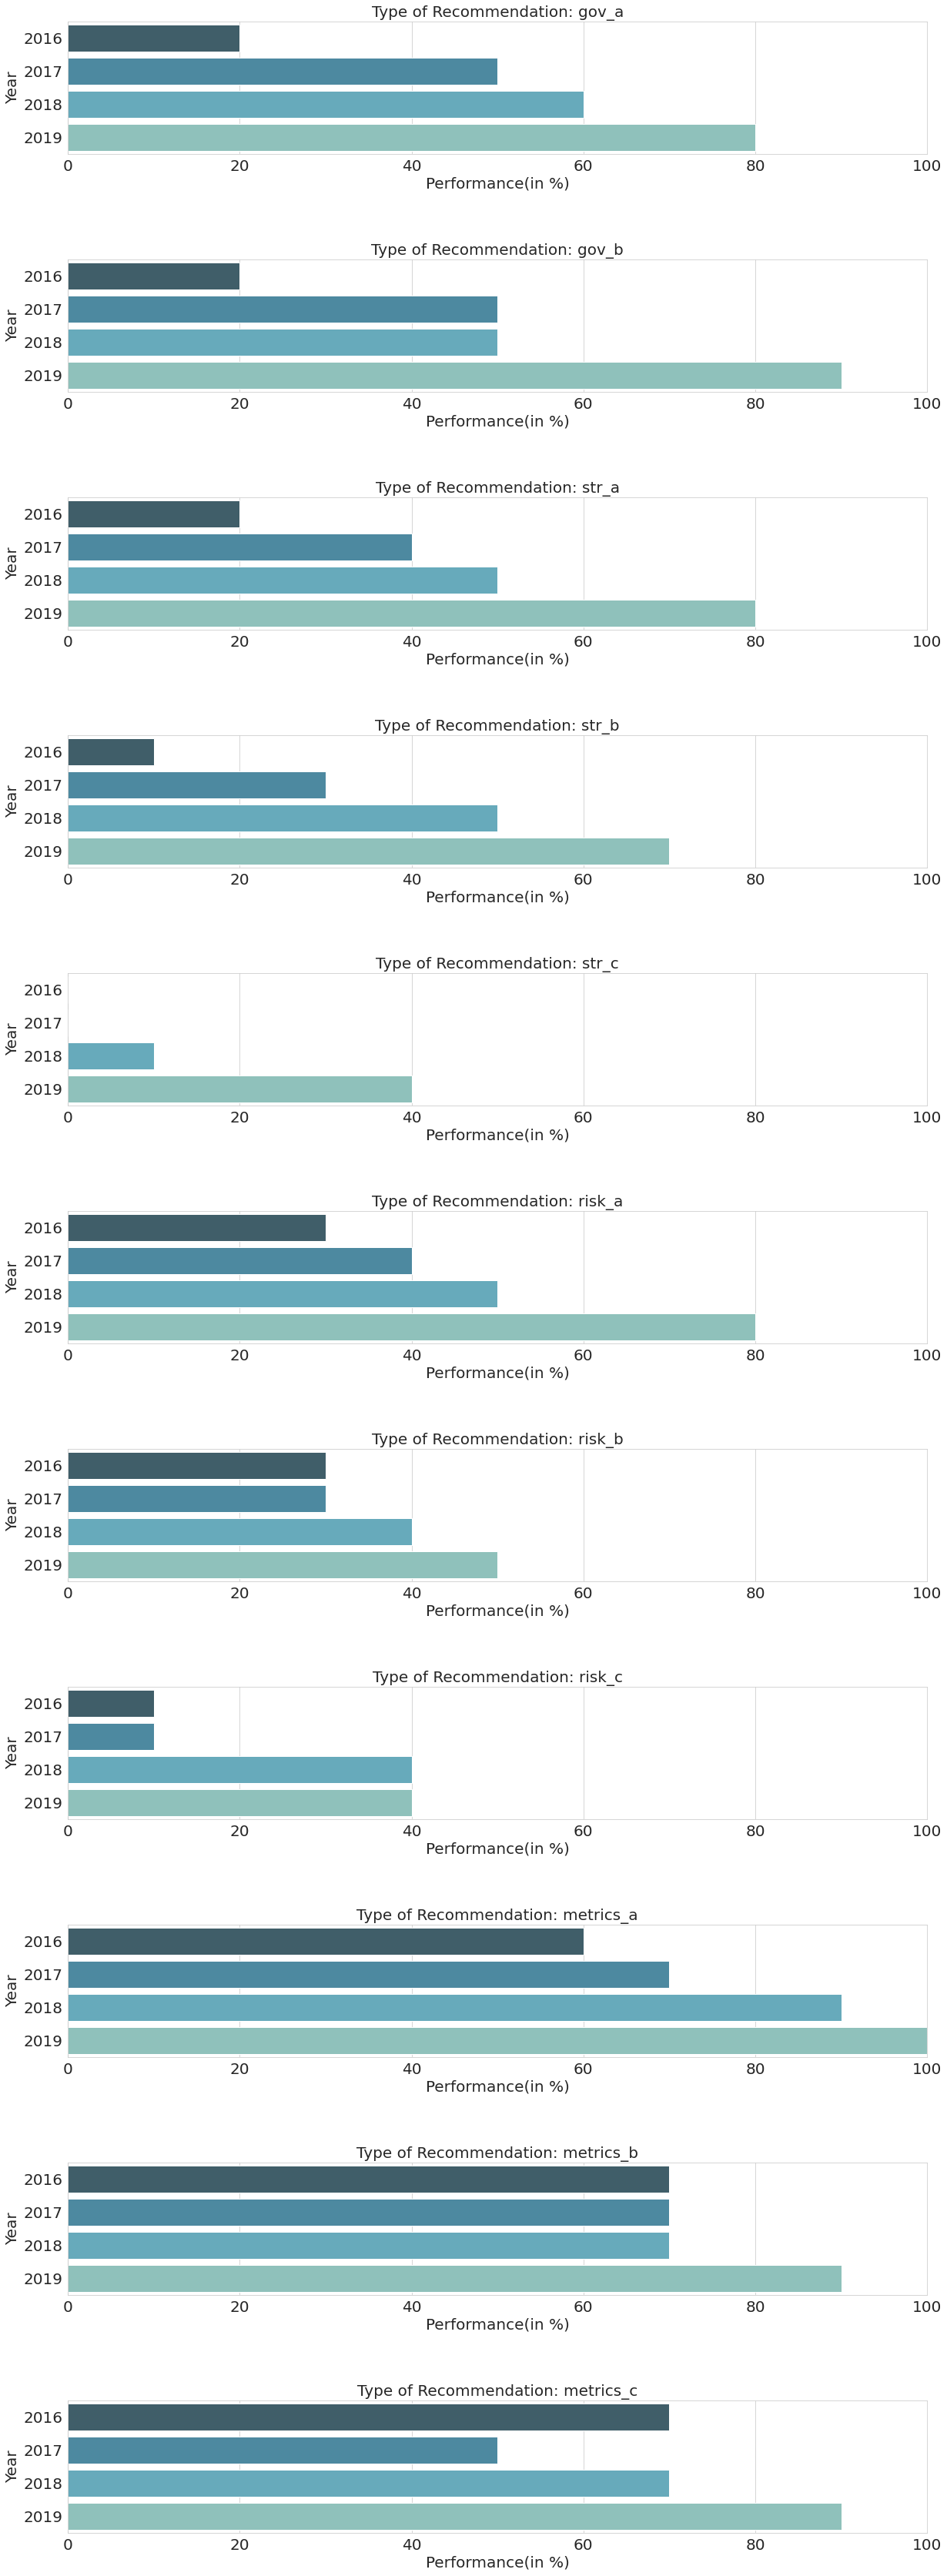

In [337]:
df_banking = df_page_short[df_page_short['Sector']=='Banking']
fig = plt.figure(figsize=(20,60))
fig.subplots_adjust(hspace=0.8, wspace=0.5)
for i, rec in enumerate(rec_list,start=1):
    per_by_year = [] 
    per_by_firm = df_banking.groupby(['firm_name','year'],as_index=False)[rec].max()
    for y in year:
        num_of_firm = df_page.loc[(df_page['Sector']=='Banking')&(df_page['year']==y)].\
            drop_duplicates(subset=['firm_name']).shape[0]
        per_mean = per_by_firm.loc[per_by_firm['year']==y,rec].sum()*100/num_of_firm
        per_by_year.append(per_mean)
    ax = fig.add_subplot(11, 1, i)
    plot_df = pd.DataFrame({'Year':year,
                          'Performance(in %)':per_by_year})
    ax.set_xlim([0,100])
    ax.set_title(f'Type of Recommendation: {rec}',fontsize=20)
    sns.barplot(x='Performance(in %)', y='Year',orient='h',palette="GnBu_d",data=plot_df)
plt.rc('axes', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('xtick', labelsize=20)

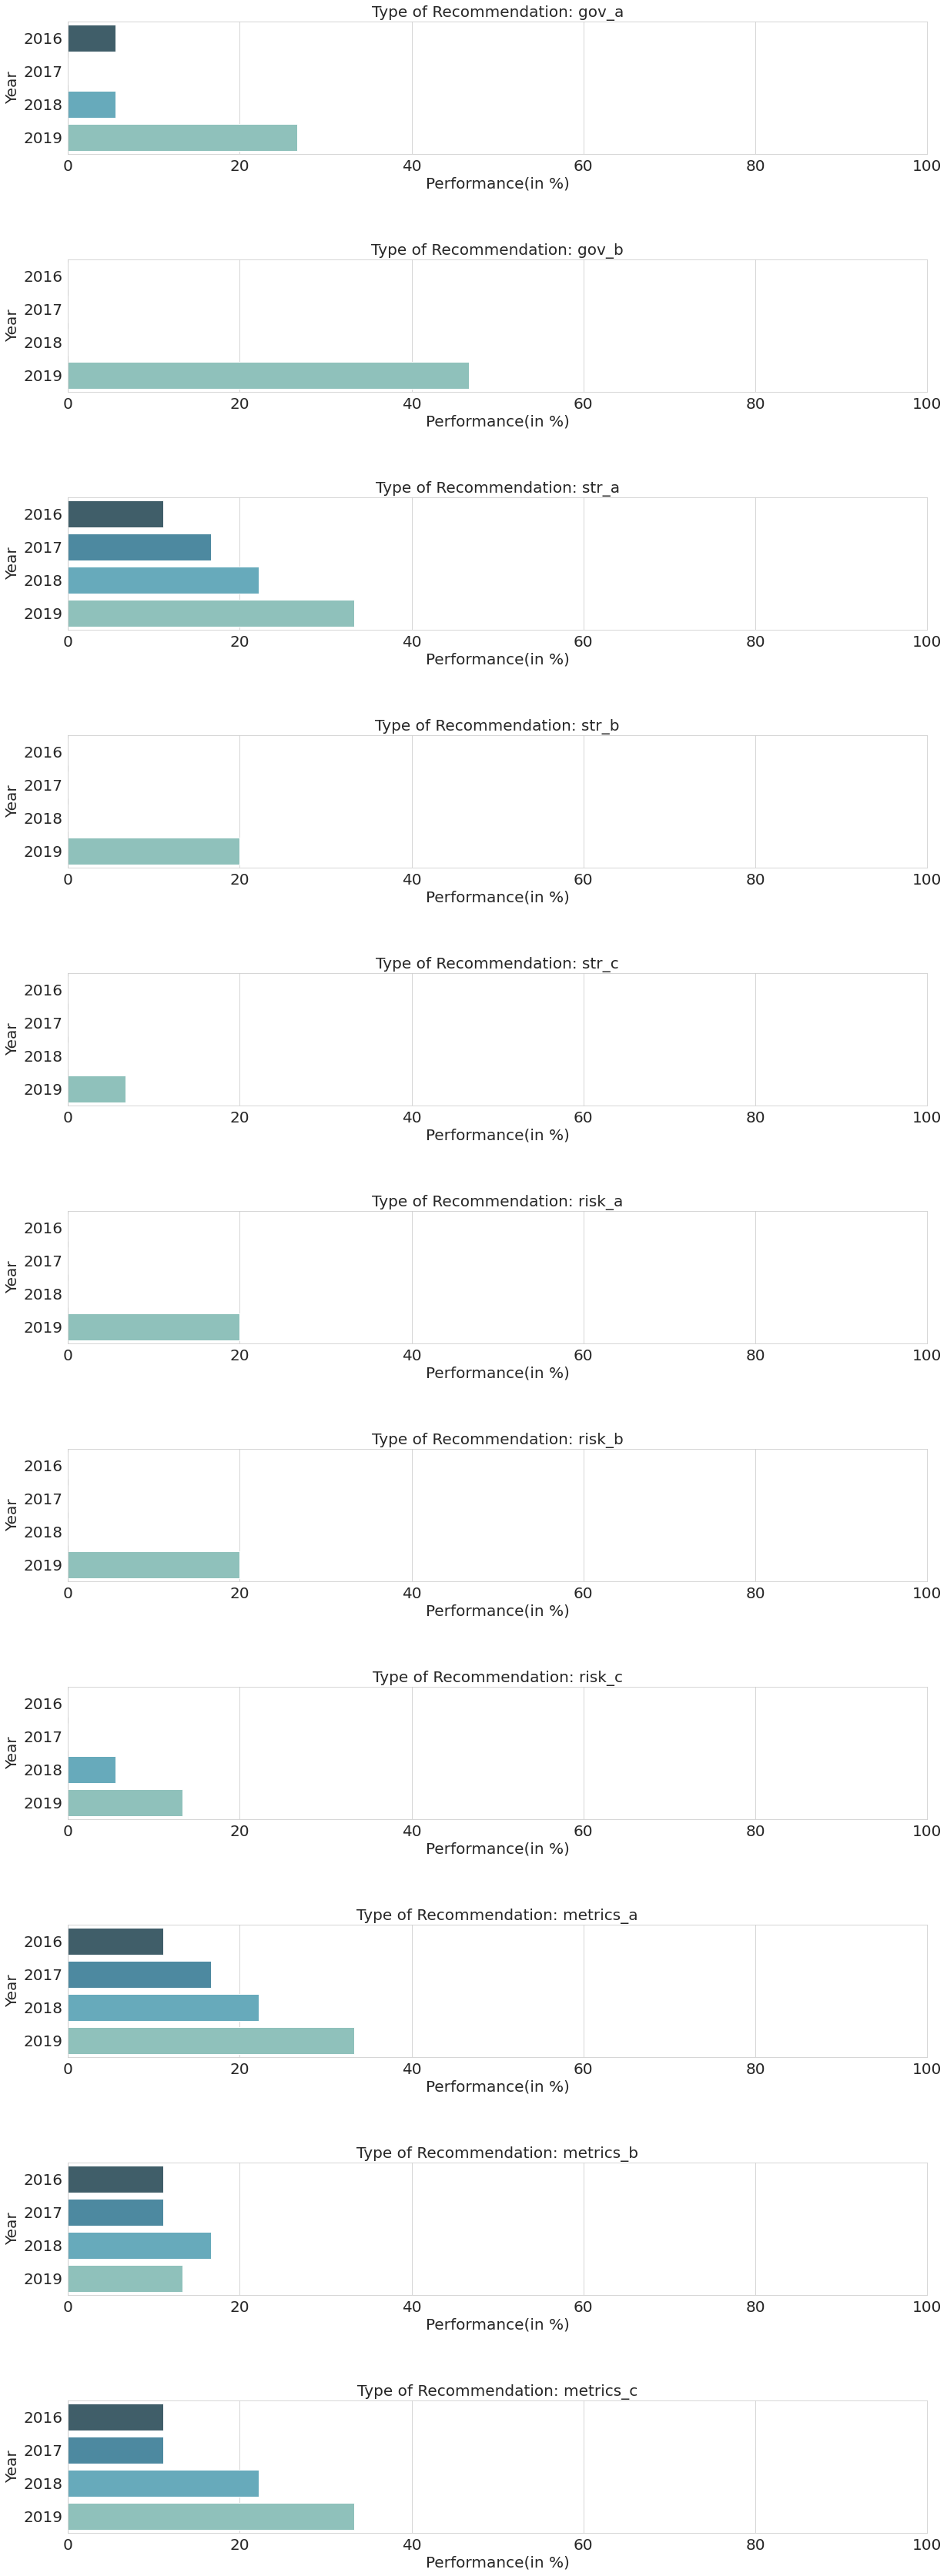

In [336]:
df_insurance = df_page_short[df_page_short['Sector']=='Insurance']
fig = plt.figure(figsize=(20,60))
fig.subplots_adjust(hspace=0.8, wspace=0.5)
for i, rec in enumerate(rec_list,start=1):
    per_by_year = [] 
    per_by_firm = df_insurance.groupby(['firm_name','year'],as_index=False)[rec].max()
    for y in year:
        num_of_firm = df_page.loc[(df_page['Sector']=='Insurance')&(df_page['year']==y)].\
            drop_duplicates(subset=['firm_name']).shape[0]
        per_mean = per_by_firm.loc[per_by_firm['year']==y,rec].sum()*100/num_of_firm
        per_by_year.append(per_mean)
    ax = fig.add_subplot(11, 1, i)
    plot_df = pd.DataFrame({'Year':year,
                          'Performance(in %)':per_by_year})
    ax.set_xlim([0,100])
    ax.set_title(f'Type of Recommendation: {rec}',fontsize=20)
    sns.barplot(x='Performance(in %)', y='Year',orient='h',palette="GnBu_d",data=plot_df)
plt.rc('axes', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('xtick', labelsize=20)

In [368]:
#Best Bank across four years
df_banking = df_page_short[df_page_short['Sector']=='Banking'].copy()
tmp = df_banking.groupby(['firm_name','year'],as_index=False)[label_unique[0:-1]].max()
tmp['Total TCFD Recomendations Satisfied'] = tmp.loc[:,label_unique[0:-1]].sum(axis=1)
tmp = tmp.groupby(['firm_name'],as_index=False)['Total TCFD Recomendations Satisfied'].sum()
tmp['Total TCFD Recomendations Satisfied (Avg)'] = tmp['Total TCFD Recomendations Satisfied']/4
tmp.sort_values(by=['Total TCFD Recomendations Satisfied (Avg)'],ascending=False,inplace=True)
tmp.rename(columns={'firm_name':'Firm Name'},inplace=True)

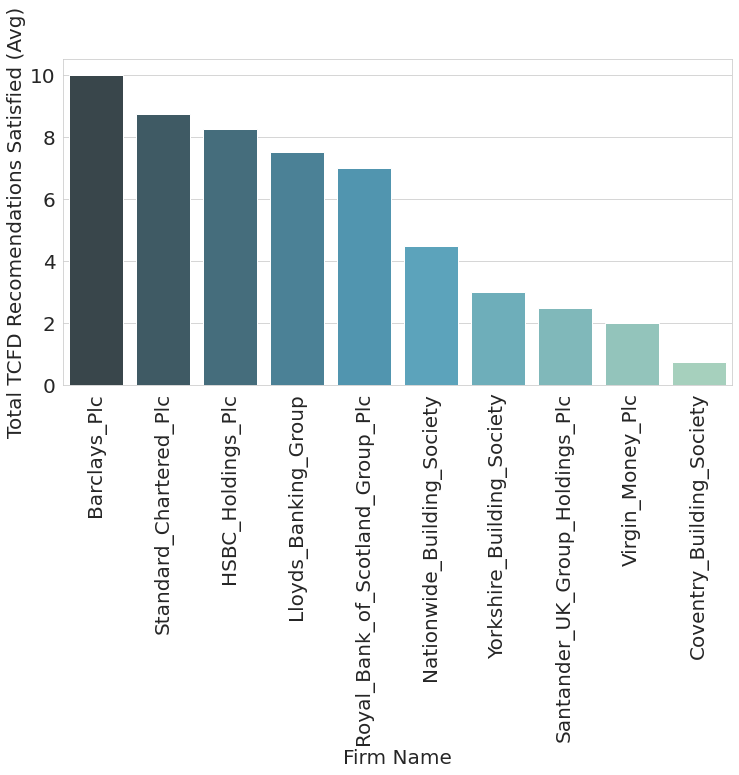

In [369]:
fig, ax = plt.subplots(figsize=(12,6))
plt.rc('font', size=12)
ax = sns.barplot(x='Firm Name', y='Total TCFD Recomendations Satisfied (Avg)',
                 data=tmp, palette='GnBu_d')
plt.xticks(rotation=90)
plt.show()

In [375]:
#Best Bank across four years
df_insurance = df_page_short[df_page_short['Sector']=='Insurance'].copy()
tmp = df_insurance.groupby(['firm_name','year'],as_index=False)[label_unique[0:-1]].max()
tmp['Total TCFD Recomendations Satisfied'] = tmp.loc[:,label_unique[0:-1]].sum(axis=1)
tmp = tmp.groupby(['firm_name'],as_index=False)['Total TCFD Recomendations Satisfied'].sum()
#take four year average for all
tmp['Total TCFD Recomendations Satisfied (Avg)'] = tmp['Total TCFD Recomendations Satisfied']/4
tmp.sort_values(by=['Total TCFD Recomendations Satisfied (Avg)'],ascending=False,inplace=True)
tmp.rename(columns={'firm_name':'Firm Name'},inplace=True)

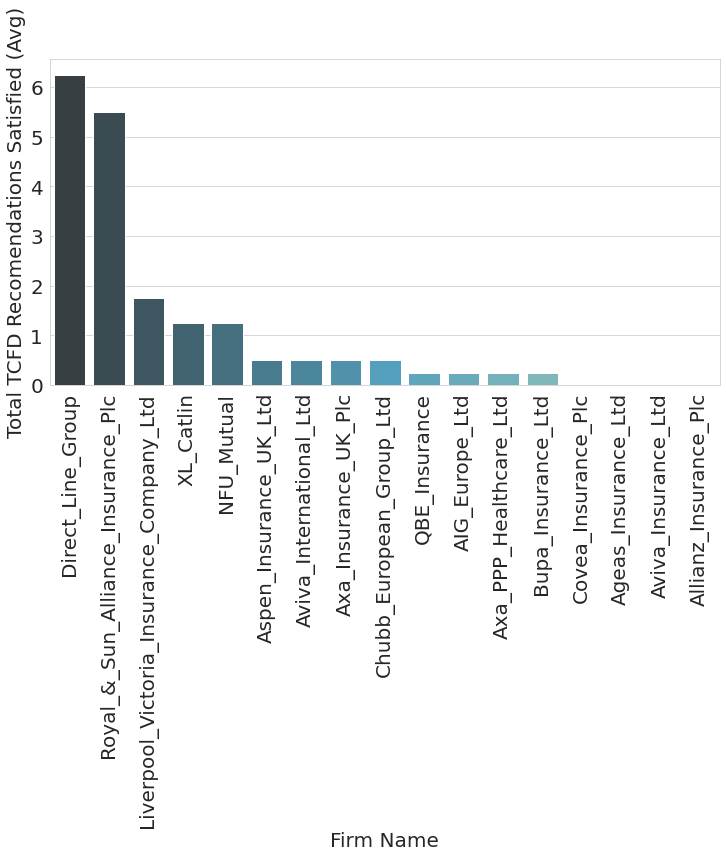

In [377]:
fig, ax = plt.subplots(figsize=(12,6))
plt.rc('font', size=12)
ax = sns.barplot(x='Firm Name', y='Total TCFD Recomendations Satisfied (Avg)',
                 data=tmp, palette='GnBu_d')
plt.xticks(rotation=90)
plt.show()

# The rest of the codes are our deep learning experiments for metrics_a, metrics_c, and risk_a, which are not included in the final dissertation because of low performace.

In [171]:
#original 

In [201]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
# build function for the Keras' scikit-learn API
def create_keras_mode_ori(input_shape): #by default trainable
    model = keras.Sequential()  # the keras Sequential class groups a linear stack of layers into a tf.keras.Model

    # Add an Embedding layer expecting input vocab, and output dimension the size of our embeddings
    # mask_zero = True tells the Embedding layer that we use index 0 for padded tokens
    model.add(keras.Input(shape=input_shape))
    model.add(layers.Dense(128,activation = 'relu')) 
    model.add(layers.Dense(32,activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
   # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [163]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [198]:
early_stopping = EarlyStopping(monitor='val_loss', 
    verbose=1,
    patience=5,
    mode='min',
    restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/project/model/tcfd_ma_ori.h5', 
    monitor='val_loss', 
    mode='min',
    save_best_only=True)
nn_metrics_a_0 = create_keras_mode_ori((174,))
tmp_X_train,tmp_y_train = SMOTE(random_state=0).fit_resample(X_train_tfidf_174
                                                             ,y_train['metrics_a'])
history_ma_0 = nn_metrics_a_0 .fit(tmp_X_train,tmp_y_train, 
                         batch_size=32,
                        validation_data=(X_val_tfidf_174,y_val['metrics_a']),
                         epochs=40,
                         verbose=2,callbacks=[early_stopping,model_checkpoint])

Epoch 1/40
10/10 - 0s - loss: 0.6795 - accuracy: 0.6069 - val_loss: 0.6804 - val_accuracy: 0.7121
Epoch 2/40
10/10 - 0s - loss: 0.6555 - accuracy: 0.7358 - val_loss: 0.6617 - val_accuracy: 0.7879
Epoch 3/40
10/10 - 0s - loss: 0.6302 - accuracy: 0.8365 - val_loss: 0.6434 - val_accuracy: 0.8182
Epoch 4/40
10/10 - 0s - loss: 0.5969 - accuracy: 0.8648 - val_loss: 0.6121 - val_accuracy: 0.8636
Epoch 5/40
10/10 - 0s - loss: 0.5493 - accuracy: 0.8962 - val_loss: 0.5774 - val_accuracy: 0.8939
Epoch 6/40
10/10 - 0s - loss: 0.4955 - accuracy: 0.9340 - val_loss: 0.5330 - val_accuracy: 0.8939
Epoch 7/40
10/10 - 0s - loss: 0.4323 - accuracy: 0.9371 - val_loss: 0.4806 - val_accuracy: 0.8939
Epoch 8/40
10/10 - 0s - loss: 0.3482 - accuracy: 0.9686 - val_loss: 0.4381 - val_accuracy: 0.8788
Epoch 9/40
10/10 - 0s - loss: 0.2695 - accuracy: 0.9717 - val_loss: 0.3883 - val_accuracy: 0.8939
Epoch 10/40
10/10 - 0s - loss: 0.2135 - accuracy: 0.9780 - val_loss: 0.3608 - val_accuracy: 0.8636
Epoch 11/40
10/10 -

In [218]:
val_pred = nn_metrics_a_0.predict(X_val_tfidf_174)>0.5
print(classification_report(y_val['metrics_a'],val_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92        52
         1.0       0.78      0.50      0.61        14

    accuracy                           0.86        66
   macro avg       0.83      0.73      0.76        66
weighted avg       0.86      0.86      0.85        66



In [207]:
early_stopping = EarlyStopping(monitor='val_loss', 
    verbose=1,
    patience=5,
    mode='min',
    restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/project/model/tcfd_mc_ori.h5', 
    monitor='val_loss', 
    mode='min',
    save_best_only=True)
nn_metrics_c_0 = create_keras_mode_ori((X_train_bow.shape[1],))
tmp_X_train,tmp_y_train = SMOTE(random_state=0).fit_resample(X_train_bow
                                                             ,y_train['metrics_c'])
history_mc_0 = nn_metrics_c_0 .fit(tmp_X_train,tmp_y_train, 
                         batch_size=20,
                        validation_data=(X_val_bow,y_val['metrics_c']),
                         epochs=40,
                         verbose=2,callbacks=[early_stopping,model_checkpoint])

Epoch 1/40
17/17 - 0s - loss: 0.5553 - accuracy: 0.7029 - val_loss: 0.3945 - val_accuracy: 0.8182
Epoch 2/40
17/17 - 0s - loss: 0.2768 - accuracy: 0.9176 - val_loss: 0.3527 - val_accuracy: 0.8182
Epoch 3/40
17/17 - 0s - loss: 0.1577 - accuracy: 0.9471 - val_loss: 0.5464 - val_accuracy: 0.8333
Epoch 4/40
17/17 - 0s - loss: 0.0844 - accuracy: 0.9765 - val_loss: 0.6218 - val_accuracy: 0.8333
Epoch 5/40
17/17 - 0s - loss: 0.0635 - accuracy: 0.9853 - val_loss: 0.6233 - val_accuracy: 0.8939
Epoch 6/40
17/17 - 0s - loss: 0.0620 - accuracy: 0.9882 - val_loss: 0.7133 - val_accuracy: 0.8636
Epoch 7/40
Restoring model weights from the end of the best epoch.
17/17 - 0s - loss: 0.0413 - accuracy: 0.9971 - val_loss: 0.7528 - val_accuracy: 0.8333
Epoch 00007: early stopping


In [209]:
val_pred = nn_metrics_c_0.predict(X_val_bow)>0.5
print(classification_report(y_val['metrics_c'],val_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.88      0.90        59
         1.0       0.22      0.29      0.25         7

    accuracy                           0.82        66
   macro avg       0.57      0.58      0.57        66
weighted avg       0.84      0.82      0.83        66



In [211]:
early_stopping = EarlyStopping(monitor='val_loss', 
    verbose=1,
    patience=5,
    mode='min',
    restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/project/model/tcfd_ra_ori.h5', 
    monitor='val_loss', 
    mode='min',
    save_best_only=True)
nn_risk_a_0 = create_keras_mode_ori((174,))
tmp_X_train,tmp_y_train = SMOTE(random_state=0).fit_resample(X_train_tfidf_174
                                                             ,y_train['risk_a'])
history_ra_0 = nn_risk_a_0.fit(tmp_X_train,tmp_y_train, 
                         batch_size=32,
                        validation_data=(X_val_tfidf_174,y_val['risk_a']),
                         epochs=40,
                         verbose=2,callbacks=[early_stopping,model_checkpoint])

Epoch 1/40
12/12 - 0s - loss: 0.6798 - accuracy: 0.6000 - val_loss: 0.6773 - val_accuracy: 0.8182
Epoch 2/40
12/12 - 0s - loss: 0.6418 - accuracy: 0.8237 - val_loss: 0.6661 - val_accuracy: 0.7879
Epoch 3/40
12/12 - 0s - loss: 0.5957 - accuracy: 0.8842 - val_loss: 0.6112 - val_accuracy: 0.8788
Epoch 4/40
12/12 - 0s - loss: 0.5347 - accuracy: 0.9368 - val_loss: 0.5407 - val_accuracy: 0.8788
Epoch 5/40
12/12 - 0s - loss: 0.4406 - accuracy: 0.9684 - val_loss: 0.4410 - val_accuracy: 0.9394
Epoch 6/40
12/12 - 0s - loss: 0.3457 - accuracy: 0.9763 - val_loss: 0.3444 - val_accuracy: 0.9394
Epoch 7/40
12/12 - 0s - loss: 0.2477 - accuracy: 0.9895 - val_loss: 0.2401 - val_accuracy: 0.9545
Epoch 8/40
12/12 - 0s - loss: 0.1778 - accuracy: 0.9868 - val_loss: 0.1832 - val_accuracy: 0.9545
Epoch 9/40
12/12 - 0s - loss: 0.1433 - accuracy: 0.9868 - val_loss: 0.1445 - val_accuracy: 0.9545
Epoch 10/40
12/12 - 0s - loss: 0.0934 - accuracy: 0.9947 - val_loss: 0.1179 - val_accuracy: 0.9545
Epoch 11/40
12/12 -

In [212]:
val_pred = nn_risk_a_0.predict(X_val_tfidf_174)>0.5
print(classification_report(y_val['risk_a'],val_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        63
         1.0       0.67      0.67      0.67         3

    accuracy                           0.97        66
   macro avg       0.83      0.83      0.83        66
weighted avg       0.97      0.97      0.97        66



In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', 
    verbose=1,
    patience=5,
    mode='min',
    restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/project/model/tcfd_mc_ori.h5', 
    monitor='val_loss', 
    mode='min',
    save_best_only=True)
nn_metrics_c_0 = create_keras_mode_ori((174,))
tmp_X_train,tmp_y_train = SMOTE(random_state=0).fit_resample(X_train_tfidf_174
                                                             ,y_train['metrics_c'])
history_mc_0 = nn_metrics_c_0 .fit(tmp_X_train,tmp_y_train, 
                         batch_size=20,
                        validation_data=(X_val_tfidf_174,y_val['metrics_c']),
                         epochs=40,
                         verbose=2,callbacks=[early_stopping,model_checkpoint])

In [148]:
from flair.embeddings import WordEmbeddings

# Load the glove embeddings
glove_embedding = WordEmbeddings('glove')
embedding_size = glove_embedding.embedding_length

In [149]:
#build vocabulary
training_paras = X_train['tokens'].values
PAD_token = '[PAD]'
OOV_token = '[OOV]'
vocab = {
    PAD_token: 0,
    OOV_token: 1
}

# Loop through all the training sentences
for para in training_paras:
    for word in para:
        if word not in vocab and word in glove_embedding.precomputed_word_embeddings.vocab:
            vocab[word] = len(vocab)  # add the word to the vocab, using the next available index
            
vocab_size = len(vocab)  # store the vocab size
print('There are {} tokens in the vocab'.format(vocab_size))

There are 3990 tokens in the vocab


In [150]:
# Initialise the embedding matrix with zeros
embedding_matrix = np.zeros(shape=(vocab_size, embedding_size))

# Now, for every word in the vocab, we will update the corresponding row in the embedding matrix with the
# pre-loaded GloVe vector
for word, word_index in vocab.items():
    if word in glove_embedding.precomputed_word_embeddings.vocab:  # if the word is in the pre-trained vocab
        word_embedding = glove_embedding.precomputed_word_embeddings.word_vec(word)
        # Save in the word_embedding matrix
        embedding_matrix[word_index, :] = word_embedding

In [151]:
mean_embedding = np.mean(embedding_matrix, axis=0)  # calculate the mean across axis 0 (i.e. across the rows)
embedding_matrix[vocab[OOV_token], :] = mean_embedding

In [153]:
def convert_words_to_indices(tokens):
    return [vocab[token] if token in vocab else vocab[OOV_token] for token in tokens]

In [155]:
X_train['para_indices'] = X_train.tokens.apply(convert_words_to_indices)
X_val['para_indices'] = X_val.tokens.apply(convert_words_to_indices)
X_test['para_indices'] = X_test.tokens.apply(convert_words_to_indices)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [156]:
longest_sequence = max(X_train['para_indices'].apply(lambda x: len(x)))
print('The longest sentence in to predict has {} tokens.'.format(longest_sequence))

The longest sentence in to predict has 736 tokens.


In [158]:
def pad_sequence(tokens: list, maxlen: int = longest_sequence) -> list:
    if maxlen>=len(tokens):
        pre = [0]*(maxlen - len(tokens))  # make a list of 0s the size that we need to prepend
        return pre + tokens
    else:
        return tokens[0:maxlen]

In [159]:
X_train['para_indices'] = X_train['para_indices'].apply(pad_sequence)
X_val['para_indices'] = X_val['para_indices'].apply(pad_sequence)
X_test['para_indices'] = X_test['para_indices'].apply(pad_sequence)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [160]:
X_train_we = np.vstack(X_train['para_indices'].values)
X_val_we = np.vstack(X_val['para_indices'].values)
X_test_we = np.vstack(X_test['para_indices'].values)

In [161]:
X_train_we_ma, y_train_ma = SMOTE(random_state=0).fit_resample(X_train_we,y_train['metrics_a'])
X_train_we_mc, y_train_mc = SMOTE(random_state=0).fit_resample(X_train_we,y_train['metrics_c'])
X_train_we_ra, y_train_ra = SMOTE(random_state=0).fit_resample(X_train_we,y_train['risk_a'])

In [162]:
import tensorflow.keras as keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
# build function for the Keras' scikit-learn API
def create_keras_model(bi,trainable): #by default trainable
    model = keras.Sequential()  # the keras Sequential class groups a linear stack of layers into a tf.keras.Model

    # Add an Embedding layer expecting input vocab, and output dimension the size of our embeddings
    # mask_zero = True tells the Embedding layer that we use index 0 for padded tokens
    model.add(layers.Embedding(input_shape=(longest_sequence,), input_dim=vocab_size, output_dim=embedding_size, input_length=longest_sequence,
                               weights=[embedding_matrix], mask_zero=True, trainable=trainable))



    if bi==True:
        model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
        model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=False,dropout=0.3, 
                                               recurrent_dropout=0.3, 
                                               kernel_regularizer=regularizers.l2(0.01))))
    else:
        model.add(layers.LSTM(128, return_sequences=True))  # SimpleRNN, LSTM, GRU, Bidirectional
        model.add(layers.LSTM(32, return_sequences=False))
        model.add(Dropout(0.3))
        
    model.add(layers.Dense(1, activation='sigmoid'))
   # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [163]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [167]:
early_stopping = EarlyStopping(monitor='val_loss', 
    verbose=1,
    patience=5,
    mode='min',
    restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/project/model/tcfd_ma_0_0.h5', 
    monitor='val_loss', 
    mode='min',
    save_best_only=True)
new_model1 = create_keras_model(bi=False,trainable=False)
history1 = new_model1.fit(X_train_we_ma, y_train_ma, 
                         batch_size=20,
                        validation_data=(X_val_we,y_val['metrics_a']),
                         epochs=40,
                         verbose=2,callbacks=[early_stopping,model_checkpoint])

Epoch 1/40
16/16 - 19s - loss: 0.7024 - accuracy: 0.5346 - val_loss: 0.6324 - val_accuracy: 0.7879
Epoch 2/40
16/16 - 17s - loss: 0.6487 - accuracy: 0.6258 - val_loss: 0.5194 - val_accuracy: 0.7576
Epoch 3/40
16/16 - 17s - loss: 0.5538 - accuracy: 0.7642 - val_loss: 0.4201 - val_accuracy: 0.8030
Epoch 4/40
16/16 - 17s - loss: 0.4655 - accuracy: 0.8270 - val_loss: 0.4355 - val_accuracy: 0.8030
Epoch 5/40
16/16 - 17s - loss: 0.4335 - accuracy: 0.8239 - val_loss: 0.4444 - val_accuracy: 0.8333
Epoch 6/40
16/16 - 16s - loss: 0.3830 - accuracy: 0.8585 - val_loss: 0.4977 - val_accuracy: 0.8030
Epoch 7/40
16/16 - 16s - loss: 0.4093 - accuracy: 0.8082 - val_loss: 0.6019 - val_accuracy: 0.7121
Epoch 8/40
Restoring model weights from the end of the best epoch.
16/16 - 16s - loss: 0.3615 - accuracy: 0.8805 - val_loss: 0.6341 - val_accuracy: 0.7879
Epoch 00008: early stopping


In [168]:
early_stopping = EarlyStopping(monitor='val_loss', 
    verbose=1,
    patience=5,
    mode='min',
    restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/project/model/tcfd_ma_0_1.h5', 
    monitor='val_loss', 
    mode='min',
    save_best_only=True)
new_model1_0_1 = create_keras_model(bi=False,trainable=True)
history1_0_1 = new_model1_0_1.fit(X_train_we_ma, y_train_ma, 
                         batch_size=20,
                        validation_data=(X_val_we,y_val['metrics_a']),
                         epochs=40,
                         verbose=2,callbacks=[early_stopping,model_checkpoint])

Epoch 1/40
16/16 - 19s - loss: 0.7031 - accuracy: 0.5189 - val_loss: 0.6523 - val_accuracy: 0.7424
Epoch 2/40
16/16 - 18s - loss: 0.6128 - accuracy: 0.6887 - val_loss: 0.4447 - val_accuracy: 0.7727
Epoch 3/40
16/16 - 18s - loss: 0.6773 - accuracy: 0.6509 - val_loss: 0.4820 - val_accuracy: 0.7576
Epoch 4/40
16/16 - 17s - loss: 0.5998 - accuracy: 0.7390 - val_loss: 0.5046 - val_accuracy: 0.7727
Epoch 5/40
16/16 - 17s - loss: 0.6009 - accuracy: 0.6604 - val_loss: 0.6046 - val_accuracy: 0.7879
Epoch 6/40
16/16 - 17s - loss: 0.5321 - accuracy: 0.7264 - val_loss: 0.5196 - val_accuracy: 0.7879
Epoch 7/40
Restoring model weights from the end of the best epoch.
16/16 - 17s - loss: 0.6845 - accuracy: 0.6069 - val_loss: 1.2474 - val_accuracy: 0.3636
Epoch 00007: early stopping


In [169]:
early_stopping = EarlyStopping(monitor='val_loss', 
    verbose=1,
    patience=5,
    mode='min',
    restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/project/model/tcfd_ma_1_0.h5', 
    monitor='val_loss', 
    mode='min',
    save_best_only=True)
new_model1_1_0 = create_keras_model(bi=True,trainable=False)
history1_1_0 = new_model1_1_0.fit(X_train_we_ma, y_train_ma, 
                         batch_size=20,
                        validation_data=(X_val_we,y_val['metrics_a']),
                         epochs=40,
                         verbose=2,callbacks=[early_stopping,model_checkpoint])

Epoch 1/40
16/16 - 40s - loss: 3.5667 - accuracy: 0.5786 - val_loss: 3.0536 - val_accuracy: 0.5758
Epoch 2/40
16/16 - 38s - loss: 2.5695 - accuracy: 0.7390 - val_loss: 2.3524 - val_accuracy: 0.5606
Epoch 3/40
16/16 - 39s - loss: 1.8207 - accuracy: 0.8208 - val_loss: 1.8137 - val_accuracy: 0.5455
Epoch 4/40
16/16 - 39s - loss: 1.4523 - accuracy: 0.7233 - val_loss: 1.5619 - val_accuracy: 0.5455
Epoch 5/40
16/16 - 39s - loss: 1.0686 - accuracy: 0.8302 - val_loss: 1.2400 - val_accuracy: 0.6364
Epoch 6/40
16/16 - 39s - loss: 0.8151 - accuracy: 0.8553 - val_loss: 0.8987 - val_accuracy: 0.6970
Epoch 7/40
16/16 - 39s - loss: 0.6286 - accuracy: 0.8931 - val_loss: 0.8919 - val_accuracy: 0.6667
Epoch 8/40
16/16 - 39s - loss: 0.5112 - accuracy: 0.8994 - val_loss: 0.9039 - val_accuracy: 0.5909
Epoch 9/40
16/16 - 39s - loss: 0.4052 - accuracy: 0.9151 - val_loss: 0.7550 - val_accuracy: 0.6818
Epoch 10/40
16/16 - 39s - loss: 0.3249 - accuracy: 0.9340 - val_loss: 0.7431 - val_accuracy: 0.6667
Epoch 11/

In [170]:
early_stopping = EarlyStopping(monitor='val_loss', 
    verbose=1,
    patience=5,
    mode='min',
    restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/project/model/tcfd_ma_1_1.h5', 
    monitor='val_loss', 
    mode='min',
    save_best_only=True)
new_model1_1_1 = create_keras_model(bi=True,trainable=True)
history1_1_1 = new_model1_1_1.fit(X_train_we_ma, y_train_ma, 
                         batch_size=20,
                        validation_data=(X_val_we,y_val['metrics_a']),
                         epochs=40,
                         verbose=2,callbacks=[early_stopping,model_checkpoint])

Epoch 1/40
16/16 - 42s - loss: 3.5112 - accuracy: 0.6101 - val_loss: 2.8622 - val_accuracy: 0.7576
Epoch 2/40
16/16 - 40s - loss: 2.4755 - accuracy: 0.7547 - val_loss: 2.3369 - val_accuracy: 0.6212
Epoch 3/40
16/16 - 40s - loss: 1.7187 - accuracy: 0.8491 - val_loss: 1.5775 - val_accuracy: 0.7424
Epoch 4/40
16/16 - 40s - loss: 1.1955 - accuracy: 0.8836 - val_loss: 1.2726 - val_accuracy: 0.7273
Epoch 5/40
16/16 - 41s - loss: 0.8594 - accuracy: 0.9057 - val_loss: 0.9392 - val_accuracy: 0.7879
Epoch 6/40
16/16 - 40s - loss: 0.6260 - accuracy: 0.9119 - val_loss: 0.9063 - val_accuracy: 0.7727
Epoch 7/40
16/16 - 41s - loss: 0.4297 - accuracy: 0.9528 - val_loss: 0.8071 - val_accuracy: 0.7273
Epoch 8/40
16/16 - 41s - loss: 0.3167 - accuracy: 0.9623 - val_loss: 0.7365 - val_accuracy: 0.7273
Epoch 9/40
16/16 - 40s - loss: 0.2486 - accuracy: 0.9717 - val_loss: 0.8257 - val_accuracy: 0.7121
Epoch 10/40
16/16 - 40s - loss: 0.1825 - accuracy: 0.9843 - val_loss: 0.7479 - val_accuracy: 0.7424
Epoch 11/

In [224]:
early_stopping = EarlyStopping(monitor='val_loss', 
    verbose=1,
    patience=5,
    mode='min',
    restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/project/model/tcfd_mc_1_1.h5', 
    monitor='val_loss', 
    mode='min',
    save_best_only=True)
new_model2_1_1 = create_keras_model(bi=True,trainable=True)
history2_1_1 = new_model2_1_1.fit(X_train_we_mc, y_train_mc, 
                         batch_size=20,
                        validation_data=(X_val_we,y_val['metrics_c']),
                         epochs=40,
                         verbose=2,callbacks=[early_stopping,model_checkpoint])

Epoch 1/40
17/17 - 33s - loss: 0.5442 - accuracy: 0.7824 - val_loss: 0.4677 - val_accuracy: 0.7879
Epoch 2/40
17/17 - 32s - loss: 0.3721 - accuracy: 0.8824 - val_loss: 0.7569 - val_accuracy: 0.6818
Epoch 3/40
17/17 - 32s - loss: 0.2729 - accuracy: 0.9147 - val_loss: 0.7437 - val_accuracy: 0.7424
Epoch 4/40
17/17 - 32s - loss: 0.2215 - accuracy: 0.9471 - val_loss: 0.7304 - val_accuracy: 0.7121
Epoch 5/40
17/17 - 32s - loss: 0.1674 - accuracy: 0.9676 - val_loss: 0.6631 - val_accuracy: 0.7273
Epoch 6/40
Restoring model weights from the end of the best epoch.
17/17 - 33s - loss: 0.1320 - accuracy: 0.9676 - val_loss: 0.6719 - val_accuracy: 0.7576
Epoch 00006: early stopping


In [227]:
early_stopping = EarlyStopping(monitor='val_loss', 
    verbose=1,
    patience=5,
    mode='min',
    restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/project/model/tcfd_ra_1_1.h5', 
    monitor='val_loss', 
    mode='min',
    save_best_only=True)
new_model3_1_1 = create_keras_model(bi=True,trainable=True)
history3_1_1 = new_model3_1_1.fit(X_train_we_ra, y_train_ra, 
                         batch_size=20,
                        validation_data=(X_val_we,y_val['risk_a']),
                         epochs=40,
                         verbose=2,callbacks=[early_stopping,model_checkpoint])

Epoch 1/40
19/19 - 39s - loss: 3.4855 - accuracy: 0.5868 - val_loss: 2.8163 - val_accuracy: 0.7121
Epoch 2/40
19/19 - 37s - loss: 2.2374 - accuracy: 0.8421 - val_loss: 1.7602 - val_accuracy: 0.8182
Epoch 3/40
19/19 - 37s - loss: 1.4067 - accuracy: 0.9079 - val_loss: 1.1053 - val_accuracy: 0.9394
Epoch 4/40
19/19 - 37s - loss: 0.9966 - accuracy: 0.8684 - val_loss: 0.8202 - val_accuracy: 0.9091
Epoch 5/40
19/19 - 37s - loss: 0.6694 - accuracy: 0.9158 - val_loss: 0.8681 - val_accuracy: 0.7727
Epoch 6/40
19/19 - 38s - loss: 0.4693 - accuracy: 0.9342 - val_loss: 0.7490 - val_accuracy: 0.7879
Epoch 7/40
19/19 - 37s - loss: 0.3145 - accuracy: 0.9500 - val_loss: 0.5149 - val_accuracy: 0.8485
Epoch 8/40
19/19 - 37s - loss: 0.2154 - accuracy: 0.9737 - val_loss: 0.3797 - val_accuracy: 0.9242
Epoch 9/40
19/19 - 37s - loss: 0.1794 - accuracy: 0.9763 - val_loss: 0.6112 - val_accuracy: 0.7879
Epoch 10/40
19/19 - 37s - loss: 0.1383 - accuracy: 0.9789 - val_loss: 0.6037 - val_accuracy: 0.8182
Epoch 11/

In [231]:
risk_a_lstm = create_keras_model(bi=True,trainable=True)
risk_a_lstm.load_weights('/project/model/tcfd_ra_1_1.h5')

val_pred = risk_a_lstm.predict(X_val_we)>0.5
print(classification_report(y_val['risk_a'],val_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.92      0.94        63
         1.0       0.00      0.00      0.00         3

    accuracy                           0.88        66
   macro avg       0.48      0.46      0.47        66
weighted avg       0.91      0.88      0.89        66

